# CMI - predictions on labeled data with ensemble voting
Here, I train only the subset of ```train.csv``` that contains the ```sii``` labels using boosted regressors (XGBoost, LightGBM and CatBoost). Even though the ```sii``` label is categorical, the ordinal nature of the label means that the class probability thresholds become important and the classification task can actually be approached using regression, with a rounding-off mechanism for making the final predictions. This notebook contains the following -
1. **Time-series statistics extraction:** Simple statistics from the time-series parquet files are calculated, extracted and appended to the ```train.csv``` and ```test.csv``` files. The time-series statistics can be parallelized in many ways. Here, it is done using ```joblib```.
2. **Cross-validation:** The data is trained and validated in a ```StratifiedKFold``` training and validation loop. I make sure to perform the required data preprocessing steps, imputation and scaling (if required), inside this loop to prevent *data leakage*. In this way, the data preprocessing pipeline can be ```fit_transform()```'d on the training set, while the validation and test sets are only ```transform()```'d. Inside the cross-validation loop, the different regressor models are fitted and the out-of-fold (OOF) predictions are calculated. Importantly, optimal thresholds for rounding-off these predictions to ordinal variables is performed.
3. **Hyperparameter Optimization:** The hyperparameter optimization was performed using ```Optuna``` and they are only stated here.

In [17]:
import glob
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.base import clone 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import cohen_kappa_score
import optuna

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

sns.set_theme()

## Data extraction
The training and test data consist of ```.csv``` files containing tabular data of over $3,000$ participants. Furthermore, the dataset also contains actigraphy data stored in ```.parquet``` files for a certain subset of participants in the form of tabular time-series.

In [2]:
folder_path = './../child-mind-institute-problematic-internet-use/'

train_df = pd.read_csv(folder_path + 'train.csv', index_col='id')
test_df = pd.read_csv(folder_path + 'test.csv', index_col='id')
data_dict = pd.read_csv(folder_path + 'data_dictionary.csv')

timeseries_train_files = glob.glob(folder_path + 'series_train.parquet/*')
timeseries_test_files = glob.glob(folder_path + 'series_test.parquet/*')

### Extracting time-series features and statistics
The actigraphy data contains a wealth of information that can be extremely helpful at predicting problematic internet usage among children and adolescents. In particular, the time-series data contains the ```enmo``` feature, which is a generalized notion of the acceleration experienced by the user's hand. Statistics of such variables, especially during the weekends, can help strenghten the training dataset, allowing for more robust predictive modeling. The ```extract_timeseries_features()``` function has been adapted from Lennard Haupt's notebook in https://www.kaggle.com/code/lennarthaupts/cmi-detecting-problematic-digital-behavior. I plan on performing a different statistical analysis on the actigraphy data later.

In [3]:
def extract_timeseries_features(df):
    ''' 
    Extracting time-series features from the actigraphy datasets.
    Copied from Lennard Haupt's notebook in https://www.kaggle.com/code/lennarthaupts/cmi-detecting-problematic-digital-behavior
    '''

    # Converting time_of_day to hours; the time_of_day variable is expressed in nanoseconds
    df["hours"] = df["time_of_day"] // (3_600 * 1_000_000_000)

    # Define conditions for night, day, and no mask (full data); night is defined to be between hours 22 and 5
    night = ((df["hours"] >= 22) | (df["hours"] <= 5))
    day = ((df["hours"] <= 20) & (df["hours"] >= 7))
    no_mask = np.ones(len(df), dtype=bool)
    # Define weekend and last week conditions
    weekend = (df["weekday"] >= 6)
    last_week = df["relative_date_PCIAT"] >= (df["relative_date_PCIAT"].max() - 7)
    # Create additional weekend features
    df["enmo_weekend"] = df["enmo"].where(weekend)
    df["anglez_weekend"] = df["anglez"].where(weekend)
    # Basic features 
    features = [
        df["non-wear_flag"].mean(),
        df["battery_voltage"].mean(),
        df["battery_voltage"].diff().mean(),
        df["relative_date_PCIAT"].tail(1).values[0]
    ]
    
    # List of columns of interest and masks
    keys = ["enmo", "anglez", "light", "enmo_weekend", "anglez_weekend"]
    masks = [no_mask, night, day, last_week]
    
    # Helper function for feature extraction
    def extract_stats(data):
        return [
            data.mean(), 
            data.std(), 
            data.max(), 
            data.min(), 
            data.kurtosis(), 
            data.skew(), 
            data.diff().mean(), 
            data.diff().std(), 
            data.diff().quantile(0.9), 
            data.diff().quantile(0.1)
        ]
    
    # Iterate over keys and masks to generate the statistics
    for key in keys:
        for mask in masks:
            filtered_data = df.loc[mask, key]
            features.extend(extract_stats(filtered_data))

    return features

def process_file(filepath):
    ''' 
    This function takes the filepath of a time-series parquet file and extracts the id number and the
    statistics defined in extract_timeseries_features() function.
    '''
    df = pd.read_parquet(filepath)
    df.drop('step', axis=1, inplace=True)

    features = extract_timeseries_features(df)
    id_num = filepath.split('=')[-1]

    return features, id_num

def extract_timeseries_id(filepath_array):
    ''' 
    This function takes an array of filepaths and returns an array of id numbers.
    '''
    id_list = []
    for n, folder in enumerate(filepath_array):
        id = folder.split('=')[-1]
        id_list.append(id)

    return id_list 

def timeseries_features_df(filepath_array, n_jobs=8):
    ''' 
    This function takes as input a filepath array and returns a dataframe with all the time-series statistics for each parquet file.
    The extraction process is sped up using Python's joblib library, with n_jobs being an optional argument.
    '''
    print('Extracting features from time-series files.')
    results = Parallel(n_jobs=n_jobs)(delayed(process_file)(f) for f in tqdm(filepath_array))

    stats, indices = zip(*results)
    df = pd.DataFrame(stats, columns=[f'stat_{i}' for i in range(len(stats[0]))])
    df['id'] = indices

    return df

The time-series statistics from the train and test parquet files are extracted into ```train_timeseries``` and ```test_timeseries``` dataframes. These are then merged with the data from the csv files.

In [4]:
train_timeseries = timeseries_features_df(timeseries_train_files)
test_timeseries = timeseries_features_df(timeseries_test_files)

Extracting features from time-series files.


  0%|          | 0/996 [00:00<?, ?it/s]

100%|██████████| 996/996 [00:38<00:00, 26.05it/s]


Extracting features from time-series files.


100%|██████████| 2/2 [00:00<00:00, 1423.49it/s]


In [5]:
timeseries_cols = train_timeseries.columns.tolist()
timeseries_cols.remove('id')

train_df = pd.merge(train_df, train_timeseries, how='left', on='id')
test_df = pd.merge(test_df, test_timeseries, how='left', on='id')

train_df.set_index('id', inplace=True)
test_df.set_index('id', inplace=True)

## Initial preprocessing
The different ```PCIAT``` columns are first removed from the training dataset. Then, I consider the subset of the data that has ```sii``` values associated with them. The numerical and categorical columns are then separated out. Here, the categorical columns are those features which are labeled as ```categorical int``` in ```data_dictionary.csv```. I will also remove any feature category that has 'Enrolment Season' or 'Season' in its descriptor.

In [6]:
train_cols = train_df.columns.tolist()
test_cols = test_df.columns.tolist()

drop_cols = list( set(train_cols) - set(test_cols) )
drop_cols.remove('sii')

train_df_subset = train_df[train_df.loc[:, 'sii'].notna()]
train_df_subset.drop(columns=drop_cols, inplace=True)

X_train = train_df_subset.loc[:, train_df_subset.columns != 'sii']
y = train_df_subset['sii'].astype('Int64')
X_test = test_df 

numerical_cols = data_dict[ (data_dict['Type']=='float') | (data_dict['Type']=='int') ]['Field'].tolist()
numerical_cols.remove('PCIAT-PCIAT_Total')
numerical_cols = numerical_cols + timeseries_cols

categorical_cols = data_dict[ data_dict['Type']=='categorical int' ]['Field'].tolist()
categorical_cols = [item for item in categorical_cols if (item not in drop_cols)]

After this inial preprocessing, the dataset comprises of $241$ numerical (most of which are comprised of time-series statistics extracted from the actigraphy files) and $11$ categorical features.

In [7]:
print(numerical_cols)
print(f'There are {len(numerical_cols)} numerical features.')

['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'stat_0', 'stat_1', 'stat_2', 'stat_3', 'stat_4', 'stat_5', 'stat_6', 'stat_7', 'stat_8', 'stat_9', 'stat_10', 'stat_11', 'stat_12', 'stat_13', 'stat_14', 'stat_15', 'stat_16', 'stat_17', 'stat_18', 'stat_19', 'stat_20', 'stat_21', 'stat_22', 'stat_23', 'stat_24', 'stat_25', 'stat_26', 'stat_27', 'stat_28', 'stat_2

In [8]:
print(categorical_cols)
print(f'There are {len(categorical_cols)} categorical features.')

['Basic_Demos-Sex', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PreInt_EduHx-computerinternet_hoursday']
There are 11 categorical features.


We can see that there is severe imbalance between the different ```sii``` classes, with ```sii``` of $0$ comprising of more than $40\%$ of the cases in the data. Hence, during cross-validation, stratification will become necessary. Even after stratification, however, the algorithm might not be able to effectively categorize ```sii``` of $3$ since it comprises of such a small proportion of the sample.

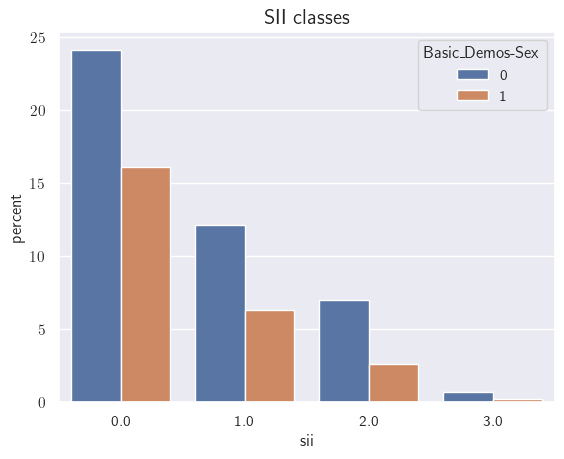

In [9]:
sns.countplot(train_df, x='sii', hue='Basic_Demos-Sex', stat='percent')
plt.title('SII classes', fontsize=15)
plt.show()

## Useful functions
We define some useful functions here. 
1. ```clipped(X, r)```: This function takes in the numerical columns of the training data as input and winsorizes only those columns for which the standard deviation is much greater than the mean, expressed as the ratio $r$. This can be an effective way of winsorizing only those features that have very large outliers (some of those in the ```BIA``` category) without fixing them by hand.
2. ```process(X, num_cols, cat_cols)```: This function performs a few simple processing steps on the data such as the aforementioned winsorization on the numerical columns and replacing occurrences of zeros with column means and converting the categorical features in ```Int64```, turning them into ordinal variables.
3. ```cross_val_QWK(reg_class, X, y, num_cols, cat_cols, cv, verbose=False)```: This function performs a whole host of tasks and is responsible for performing stratified $k$-fold cross-validation and making predictions. Apart from these steps, this function also performs the following - 
    * **Data preprocessing:** This is done inside the cross-validation loop to prevent data leakage. 
    * $\kappa$ **-scores:** The weighted $\kappa$ scores are calculated for both training and validation sets at each fold using the ```quadratic_weighted_kappa(y_true, y_pred)``` function. The validation set predictions here are labeled ```oof``` (out-of -fold) for wihch there are ```oof_not_rounded``` and ```oof_rounded```, where the former arises from the fact that the model is being trained with regressors. The rounding thresholds can be the default $x_0=\left[ 0.5, 1.5, 2.5 \right]$ or a optimal set of thresholds by maximizing $\kappa$. This optimized threshold $x_{0,\text{opt}}$ is then used to round-off the mean predictions over the $k$-folds of cross-validation.
4. ```objective(trial, reg, X, y, num_cols, cat_cols, cv, verbose=False)``` and ```hyperparam_optim(reg, X, y, num_cols, cat_cols, n_trials=25, cv=5)```: These functions perform hyperparameter optimization using ```Optuna```.

In [29]:
def clipped(X, r):
    ''' 
    This function caps the numerical columns to the specified upper and lower quantiles on respective ends. It does so for those featutres
    for which the standard deviation is much greater or equal the mean. This is passed as a desired ratio of std/mean.
    '''
    X_clipped = X.copy()

    ratio = X_clipped.std() / X_clipped.mean()
    idx_list = ratio[ ratio.where(ratio >= r).notna() ].index.tolist()

    for idx in idx_list:
        lq = X_clipped[idx].quantile(0.05)
        uq = X_clipped[idx].quantile(0.95)
        X_clipped.loc[:, idx] = X_clipped.loc[:, idx].clip(lower=lq, upper=uq)

    return X_clipped

def process(X, num_cols, cat_cols):
    ''' 
    This function performs preprocessing on the data. The training data is first split into numerical and categorical features.
    '''
    X_numerical = X[num_cols]

    X_categorical = X[cat_cols]
    X_categorical = X_categorical.astype('Int64')

    # Some numerical features have erroneous zero values - e.g. BMI, blood pressure etc
    # Winsorize X_numerical and replace occurrences of zero with feature mean

    X_numerical = clipped(X_numerical, 1.5)
    X_numerical.replace(0, X_numerical.mean(axis=0), inplace=True)

    X_processed = X_categorical.join(X_numerical)

    return X_processed

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_rounder(oof_not_rounded, thresholds):
    ''' 
    This function iteratively rounds up (or down) the validation set predictions using a predefined threshold passed as an array.
    By default, the thresholds can be set as [0.5, 1.5, 2.5], such that predicts lesser (or greater) than the thresholds will be
    rounded to the nearest integer.
    
    This function can be particularly useful when one wishes to implement a custom rounding threshold.
    '''
    thresh_0, thresh_1, thresh_2 = thresholds # unpack the thresholds

    return np.where(
        oof_not_rounded < thresh_0, 0, np.where(oof_not_rounded < thresh_1, 1, np.where(oof_not_rounded < thresh_2, 2, 3))
    )

def evaluate_predictions(thresholds, y, oof_not_rounded):
	y_pred_rounded = threshold_rounder(oof_not_rounded, thresholds)
	return -quadratic_weighted_kappa(y, y_pred_rounded)

def cross_val_QWK(reg_class, X, y, num_cols, cat_cols, cv, verbose=False):
    ''' 
    This function takes in a particular classifier and training data and perfoms Stratified k-Fold cross-validation on it
    and calculates the out-of-fold (OOF) QWK score.
    '''
    X = process(X, num_cols, cat_cols)
    N_SPLITS = cv
    train_scores = [] # training QWK scores across folds
    val_scores = []   # validation QWK scores across folds

    oof_not_rounded = np.zeros(len(y), dtype=np.float32) # array for storing out-of-fold prediction from regressor
    oof_rounded = np.zeros(len(y), dtype=np.int32) # array for storing out-of-fold prediction that has been rounded
    y_pred = np.zeros((len(X_test), N_SPLITS))
    
    SKF = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)

    ''' 
    Performing Stratified k-fold cross validation with n_splits=5; the training set XX will be further
    split into training and validation sets a total of n_split times. The data preprocessing steps (imputation and scaling)
    will be applied here to prevent data leakage.
    '''
    for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):

        # Breaking up the training data into further training and validation sets during each iteration
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        # Data pre-processing

        numerical_transformer = Pipeline(
            steps=[
                ('imp_num', KNNImputer(n_neighbors=5, weights='uniform')),
                #('imp_num', SimpleImputer(strategy='mean')),
                #('ss', StandardScaler())
            ]
        )

        categorical_transformer = Pipeline(
            steps=[
                ('imp_cat', KNNImputer(n_neighbors=5, weights='uniform')),
                #('imp_cat', SimpleImputer(strategy='most_frequent')),
            ]
        )

        preprocessor = ColumnTransformer(
            transformers=[
                ('numerical_transforms', numerical_transformer, num_cols),
                ('categorical_transforms', categorical_transformer, cat_cols[1:])
            ], remainder='passthrough'
        )

        preprocessor.set_output(transform='pandas')
        X_train = preprocessor.fit_transform(X_train)
        X_val = preprocessor.transform(X_val)
        test_data = preprocessor.transform(X_test)

        reg = clone(reg_class)
        reg.fit(X_train, y_train)

        y_train_pred = reg.predict(X_train)
        y_val_pred = reg.predict(X_val)

        oof_not_rounded[test_idx] = y_val_pred
        oof_rounded[test_idx] = y_val_pred.round(0).astype('int32')

        kappa_train = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype('int32'))
        kappa_val = quadratic_weighted_kappa(y_val, y_val_pred.round(0).astype('int32'))

        train_scores.append(kappa_train)
        val_scores.append(kappa_val)
        y_pred[:, fold] = reg.predict(test_data)

        if verbose:

            print(f'Fold {fold + 1}: Training QWK = {kappa_train:.4f}, Validation QWK: {kappa_val:.4f}')

    if verbose:

        print(f'Mean training QWK = {np.mean(train_scores):.4f}')
        print(f'Mean validation QWK = {np.mean(val_scores):.4f}')

    ''' 
    In kappa_optimizer the QWK metric is maximized (or rather the negative QWK is minimize) to obtain a set of optimal 
    rounding threshold values.
    '''
    kappa_optimizer = minimize(evaluate_predictions, x0 = [0.5, 1.5, 2.5], args=(y, oof_not_rounded), method='Nelder-Mead')
    threshold_optim = kappa_optimizer.x
    #assert kappa_optimizer.succes, 'Optimizer did not converge.'

    oof_tuned = threshold_rounder(oof_not_rounded, threshold_optim)
    kappa_val_tuned = quadratic_weighted_kappa(y, oof_tuned)

    print(f'Tuned QWK = {kappa_val_tuned}')

    y_pred_mean = threshold_rounder(y_pred.mean(axis=1), threshold_optim)

    return y_pred_mean 
    

def objective(trial, reg, X, y, num_cols, cat_cols, cv, verbose=False):
    ''' 
    This function performs hyperparameter optimization using Optuna for a given classifier model.
    '''

    if reg == 'XGBoost':
        # Hyperparameters for XGBoost regressor
        params = {
            'objective' : trial.suggest_categorical('objective', ['reg:squarederror', 'reg:absoluteerror', 'reg:pseudohubererror']),
            'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
            'max_depth' : trial.suggest_int('max_depth', 5, 15),
            'learning_rate' : trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'gamma' : trial.suggest_float('gamma', 0.0, 5.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 0.1, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 0.1, log=True),
            'subsample' : trial.suggest_float('subsample', 0.5, 1.0)
        }

        model = XGBRegressor(**params)

    elif reg == 'LightGBM':
        # Hyperparameters for LightGBM regressor
        params = {
            'objective' : trial.suggest_categorical('objective', ['regression', 'poisson', 'quantile']),
            'verbosity' : -1,
            'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
            'max_depth' : trial.suggest_int('max_depth', 5, 15),
            'learning_rate' : trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'subsample' : trial.suggest_float('subsample', 0.5, 1.0)
        }

        model = LGBMRegressor(**params)

    elif reg == 'CatBoost':
        # Hyperparameters for CatBoost regressor
        params = {
            'objective' : trial.suggest_categorical('objective', ['RMSE', 'Poisson', 'Quantile']),
            'iterations': trial.suggest_int('iterations', 200, 500),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 0.1, log=True),
            #'subsample': trial.suggest_float('subsample', 0.5, 1.0)
        }

        model = CatBoostRegressor(**params, verbose=0)

    else:

        raise ValueError(f'Unsupported regressor type: {reg}')
    
    val_QWK = cross_val_QWK(model, X, y, num_cols, cat_cols, cv)

    return val_QWK

def hyperparam_optim(reg, X, y, num_cols, cat_cols, n_trials=25, cv=5): 
    study = optuna.create_study(direction='maximize')
    study.optimize(
        lambda trial: objective(trial, reg, X, y, num_cols, cat_cols, cv),
        n_trials=n_trials 
    )

    print(f'Best parameters for {reg}: {study.best_params}')
    print(f'Best QWK score: {study.best_value}')
    return study.best_params

### Predictions

In [30]:
 # validation QWK = 0.369
xgb_params = {
    'objective': 'reg:pseudohubererror',
    'n_estimators': 157,
    'max_depth': 8,
    'learning_rate': 0.03747807982154853,
    'gamma': 3.3972493317616235,
    'reg_alpha': 0.019288617659988346,
    'reg_lambda': 1.1622365647503362e-05,
    'subsample': 0.5463994889151166
}

# validation QWK = 0.394
lgb_params = {
    'objective': 'regression',
    'n_estimators': 438,
    'max_depth': 12,
    'learning_rate': 0.011007625265216012,
    'subsample': 0.9500505257332115
}

# validation QWK = 0.382
cb_params = {
    'objective': 'Poisson',
    'iterations': 410,
    'depth': 4,
    'learning_rate': 0.03217561086495608,
    'l2_leaf_reg': 0.0030777935770974554
}

xgb_reg = XGBRegressor(**xgb_params)
lgb_reg = LGBMRegressor(**lgb_params, verbosity=-1)
cb_reg = CatBoostRegressor(**cb_params, verbose=0)

voting_reg = VotingRegressor(
    estimators=[
        ('XGBoost', xgb_reg),
        ('LightGBM', lgb_reg),
        ('CatBoost', cb_reg)
    ],
    weights = [1, 1, 1]
)

y_pred = cross_val_QWK(voting_reg, X_train, y, numerical_cols, categorical_cols, cv=5, verbose=True)

Fold 1: Training QWK = 0.7567, Validation QWK: 0.3975
Fold 2: Training QWK = 0.7621, Validation QWK: 0.3876
Fold 3: Training QWK = 0.7534, Validation QWK: 0.3323
Fold 4: Training QWK = 0.7595, Validation QWK: 0.4193
Fold 5: Training QWK = 0.7547, Validation QWK: 0.3425
Mean training QWK = 0.7573
Mean validation QWK = 0.3758
Tuned QWK = 0.4491222179082237


In [12]:
output = pd.DataFrame({'id': X_test.index.tolist(), 'sii': y_pred})

In [13]:
output.to_csv('submission.csv', index=False)